# FINAL PROJECT: Intelligent Data Analysis


**1.   Group infomation:**


- 1753037 - Nguyễn Phúc Đăng
- 1753097 - Lê Nguyễn Minh Tâm

**2.   Description:**


 In this project, our group perform an analysis on a **EM-DAT** natural disasters data set to find these relevant insights:
 - Country is most impacted by natural disasters by visualize data using Tableau
 - Short-term prediction of Global's number of Disaster Ocurrence by using Arima






# Libraries

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

warnings.filterwarnings("ignore") 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

In this Project, we using disaster data from EM-DAT(https://public.emdat.be/data) 

In [2]:
df= pd.read_csv("/content/drive/MyDrive/FinalProject-Disaster Data Analysis/desaster1980_2019.csv")
df.head()

,Dis No,Year,Seq,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Entry Criteria,Country,ISO,Region,Continent,Location,Origin,Associated Dis,Associated Dis2,OFDA Response,Appeal,Declaration,Aid Contribution,Dis Mag Value,Dis Mag Scale,Latitude,Longitude,Local Time,River Basin,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,No Injured,No Affected,No Homeless,Total Affected,Reconstruction Costs ('000 US$),Insured Damages ('000 US$),Total Damages ('000 US$),CPI
0,1980-9114-CIV,1980,9114,Natural,Climatological,Drought,Drought,NaN,NaN,NaN,Côte d’Ivoire,CIV,Western Africa,Africa,Central,NaN,Food shortage,Crop failure,NaN,NaN,NaN,NaN,NaN,Km2,NaN,NaN,NaN,NaN,1983,NaN,NaN,1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.233893
1,1980-0096-DZA,1980,96,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Kill,Algeria,DZA,Northern Africa,Africa,El Asnam,NaN,Tsunami/Tidal wave,NaN,Yes,NaN,NaN,NaN,7.0,Richter,36.195,1.354,13:25,NaN,1980,10.0,10.0,1980,10.0,10.0,2633.0,8369.0,478948.0,443000.0,930317.0,NaN,NaN,5200000.0,32.233893
2,1980-9114-GHA,1980,9114,Natural,Climatological,Drought,Drought,NaN,NaN,NaN,Ghana,GHA,Western Africa,Africa,Countrywide,NaN,Wildfire,NaN,Yes,NaN,NaN,NaN,NaN,Km2,NaN,NaN,NaN,NaN,1983,10.0,NaN,1985,NaN,NaN,NaN,NaN,12500000.0,NaN,12500000.0,NaN,NaN,NaN,32.233893
3,1980-0078-HTI,1980,78,Natural,Meteorological,Storm,Tropical cyclone,NaN,Allen,Kill,Haiti,HTI,Caribbean,Americas,"South-West, Port-Au-Prince",NaN,Flood,NaN,Yes,No,No,NaN,270.0,Kph,NaN,NaN,NaN,NaN,1980,8.0,5.0,1980,8.0,5.0,220.0,NaN,330000.0,835000.0,1165000.0,NaN,NaN,400000.0,32.233893
4,1980-9114-BEN,1980,9114,Natural,Climatological,Drought,Drought,NaN,NaN,NaN,Benin,BEN,Western Africa,Africa,"Oueme, Zou, Borgou, Atacora provinces",NaN,Food shortage,NaN,NaN,No,No,NaN,NaN,Km2,NaN,NaN,NaN,NaN,1983,1.0,NaN,1985,NaN,NaN,NaN,NaN,2100000.0,NaN,2100000.0,NaN,NaN,651.0,32.233893


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13009 entries, 0 to 13008
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Dis No                           13009 non-null  object 
 1   Year                             13009 non-null  int64  
 2   Seq                              13009 non-null  int64  
 3   Disaster Group                   13009 non-null  object 
 4   Disaster Subgroup                13009 non-null  object 
 5   Disaster Type                    13009 non-null  object 
 6   Disaster Subtype                 10871 non-null  object 
 7   Disaster Subsubtype              951 non-null    object 
 8   Event Name                       3269 non-null   object 
 9   Entry Criteria                   12819 non-null  object 
 10  Country                          13009 non-null  object 
 11  ISO                              13009 non-null  object 
 12  Region            

- We drop columns which missing a lots of data and don't really help in this project 



In [4]:
df =df.drop(["No Injured","Dis No","Seq","Disaster Group","Disaster Subsubtype","Event Name",
             "Associated Dis2", "OFDA Response","Appeal","Declaration","Aid Contribution",
             "Dis Mag Value","Dis Mag Scale","Latitude","Longitude","Local Time","River Basin",
             "Start Year","Start Month","Start Day","Origin","Reconstruction Costs ('000 US$)",
             "Insured Damages ('000 US$)","Total Damages ('000 US$)","CPI","No Affected","No Homeless",
             "End Month","End Day", "End Year","Disaster Subtype","Associated Dis"], axis=1)

In [5]:
df

,Year,Disaster Subgroup,Disaster Type,Entry Criteria,Country,ISO,Region,Continent,Location,Total Deaths,Total Affected
0,1980,Climatological,Drought,NaN,Côte d’Ivoire,CIV,Western Africa,Africa,Central,NaN,NaN
1,1980,Geophysical,Earthquake,Kill,Algeria,DZA,Northern Africa,Africa,El Asnam,2633.0,930317.0
2,1980,Climatological,Drought,NaN,Ghana,GHA,Western Africa,Africa,Countrywide,NaN,12500000.0
3,1980,Meteorological,Storm,Kill,Haiti,HTI,Caribbean,Americas,"South-West, Port-Au-Prince",220.0,1165000.0
4,1980,Climatological,Drought,NaN,Benin,BEN,Western Africa,Africa,"Oueme, Zou, Borgou, Atacora provinces",NaN,2100000.0
...,...,...,...,...,...,...,...,...,...,...,...
13004,2019,Hydrological,Flood,Affected,South Africa,ZAF,Southern Africa,Africa,Pretoria and Gauteng Province,2.0,3500.0
13005,2019,Hydrological,Flood,Kill,Congo (the Democratic Republic of the),COD,Middle Africa,Africa,"Nord - Ubangi, Sud -Ubangi, Mongala, Bas -Uele...",43.0,399894.0
13006,2019,Hydrological,Landslide,Kill,Congo (the Democratic Republic of the),COD,Middle Africa,Africa,Ituri Province,24.0,NaN
13007,2019,Biological,Epidemic,Kill,Congo (the Democratic Republic of the),COD,Middle Africa,Africa,NaN,472.0,27000.0


# Clean Data

- There still missing datas so we now clean them

**Clean Location**

---

We fill location's missing data which "unknown" value

In [6]:
df['Location']=df['Location'].fillna('unknown')

**Clean Entry Criteria**

---



In [7]:
print("No of Nan remain in Entry Criteria column:", df['Entry Criteria'].isna().sum())

No of Nan remain in Entry Criteria column: 190


In [8]:
for iso in np.unique(df['ISO']):
  for dis in np.unique(df['Disaster Type']):
    tmp = df[(df['ISO']==iso) & (df['Disaster Type']==dis)]
    if not tmp['Entry Criteria'].empty:
      res = max(set(list(tmp['Entry Criteria'])), key = list(tmp['Entry Criteria']).count)
      df.loc[(df['ISO']==iso) & (df['Disaster Type']==dis), "Entry Criteria"] = df.loc[(df['ISO']==iso) & (df['Disaster Type']==dis), "Entry Criteria"].fillna(res)
print("No of Nan remain in Entry Criteria column:", df['Entry Criteria'].isna().sum())

No of Nan remain in Entry Criteria column: 100


In [9]:
for iso in np.unique(df['ISO']):
  tmp = df[df['ISO']==iso]
  if not tmp['Entry Criteria'].empty:
    res = max(set(list(tmp['Entry Criteria'])), key = list(tmp['Entry Criteria']).count)
    df.loc[df['ISO']==iso, "Entry Criteria"] = df.loc[df['ISO']==iso, "Entry Criteria"].fillna(res)
print("No of Nan remain in Entry Criteria column:", df['Entry Criteria'].isna().sum())

No of Nan remain in Entry Criteria column: 0


Clean Total Deaths and Total Affected

---



In [10]:
print("No of Nan remain in Total Deaths column:", df['Total Deaths'].isna().sum(),"\n")
print("No of Nan remain in Total Affected column:", df['Total Affected'].isna().sum())

No of Nan remain in Total Deaths column: 3907 

No of Nan remain in Total Affected column: 3160


In [11]:
for iso in np.unique(df['ISO']):
  for dis in np.unique(df['Disaster Type']):
    tmp = df[(df['ISO']==iso) & (df['Disaster Type']==dis)]
    mean_dths = np.mean(tmp['Total Deaths'])
    mean_aff = np.mean(tmp['Total Affected'])
    df.loc[(df['ISO']==iso) & (df['Disaster Type']==dis), "Total Deaths"] = df.loc[(df['ISO']==iso) & (df['Disaster Type']==dis), "Total Deaths"].fillna(mean_dths)
    df.loc[(df['ISO']==iso) & (df['Disaster Type']==dis), "Total Affected"] = df.loc[(df['ISO']==iso) & (df['Disaster Type']==dis), "Total Affected"].fillna(mean_aff)
print("No of Nan remain in Total Deaths column:", df['Total Deaths'].isna().sum(),"\n")
print("No of Nan remain in Total Affected column:", df['Total Affected'].isna().sum())

No of Nan remain in Total Deaths column: 724 

No of Nan remain in Total Affected column: 394


In [12]:
for dis in np.unique(df['Disaster Type']):
  tmp = df[df['Disaster Type']==dis]
  mean_dths = np.mean(tmp['Total Deaths'])
  mean_aff = np.mean(tmp['Total Affected'])
  df.loc[df['Disaster Type']==dis, "Total Deaths"] = df.loc[df['Disaster Type']==dis, "Total Deaths"].fillna(mean_dths)
  df.loc[df['Disaster Type']==dis, "Total Affected"] = df.loc[df['Disaster Type']==dis, "Total Affected"].fillna(mean_aff)
print("No of Nan remain in Total Deaths column:", df['Total Deaths'].isna().sum(),"\n")
print("No of Nan remain in Total Affected column:", df['Total Affected'].isna().sum())

No of Nan remain in Total Deaths column: 87 

No of Nan remain in Total Affected column: 0


In [13]:
for dis in np.unique(df['ISO']):
  tmp = df[df['ISO']==dis]
  mean = np.mean(tmp['Total Deaths'])
  df.loc[df['ISO']==dis, "Total Deaths"] =  df.loc[df['ISO']==dis, "Total Deaths"].fillna(mean)
print("No of Nan remain in Total Deaths column:", df['Total Deaths'].isna().sum())

No of Nan remain in Total Deaths column: 0


In [14]:
df['Total Deaths'] = df['Total Deaths'].astype(int)
df['Total Affected'] = df['Total Affected'].astype(int)

In [15]:
print(df.isna().sum())

Year                 0
Disaster Subgroup    0
Disaster Type        0
Entry Criteria       0
Country              0
ISO                  0
Region               0
Continent            0
Location             0
Total Deaths         0
Total Affected       0
dtype: int64


In [16]:
df.to_csv("natural_disaster.csv")

# Visualize

In [17]:
noDisPerCtr = df.groupby(["Country"])["Disaster Type"].count()
noDisPerCtr.astype('float')
noDisPerCtr_df = pd.DataFrame(noDisPerCtr)
noDisPerCtr_df.columns = ["No Dis"]
noDisPerCtr_df.to_csv("Disaster_per_Country.csv")

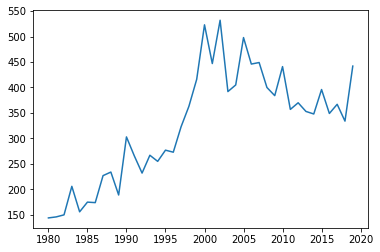

In [18]:
noDisPerYrs = df.groupby(["Year"])["Disaster Type"].count()
noDisPerYrs.astype('float')
noDisPerYrs_df = pd.DataFrame(noDisPerYrs)
noDisPerYrs_df.columns = ["No Dis"]
plt.plot(noDisPerYrs_df)
plt.show()

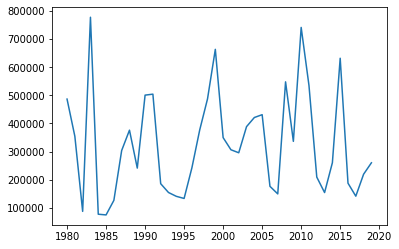

In [19]:
totalDths = df.groupby(["Year"])["Total Deaths"].sum()
totalDths.astype('float')
totalDths_df = pd.DataFrame(totalDths)
plt.plot(totalDths_df)
plt.show()

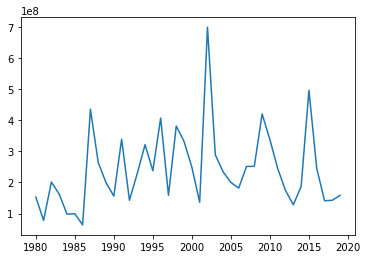

In [20]:
totalAff = df.groupby(["Year"])["Total Affected"].sum()
totalAff.astype('float')
totalAff_df = pd.DataFrame(totalAff)
plt.plot(totalAff_df)
plt.show()

# Predict Number of Disaster Ocurrence with Arima

In [21]:
ts = df.groupby(["Year"])["Disaster Type"].count()
ts.astype('float')
indexedDataset = pd.DataFrame(ts)
indexedDataset.head()

,Disaster Type
Year,
1980,144
1981,146
1982,150
1983,206
1984,156


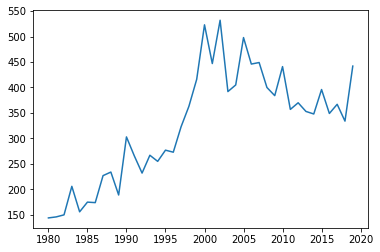

In [22]:

plt.plot(indexedDataset)
plt.show()


In [23]:
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [24]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -1.630215
p-value                         0.467378
#Lags Used                      1.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


In [25]:
dataAR = list(indexedDataset["Disaster Type"].values)
len(dataAR)

40

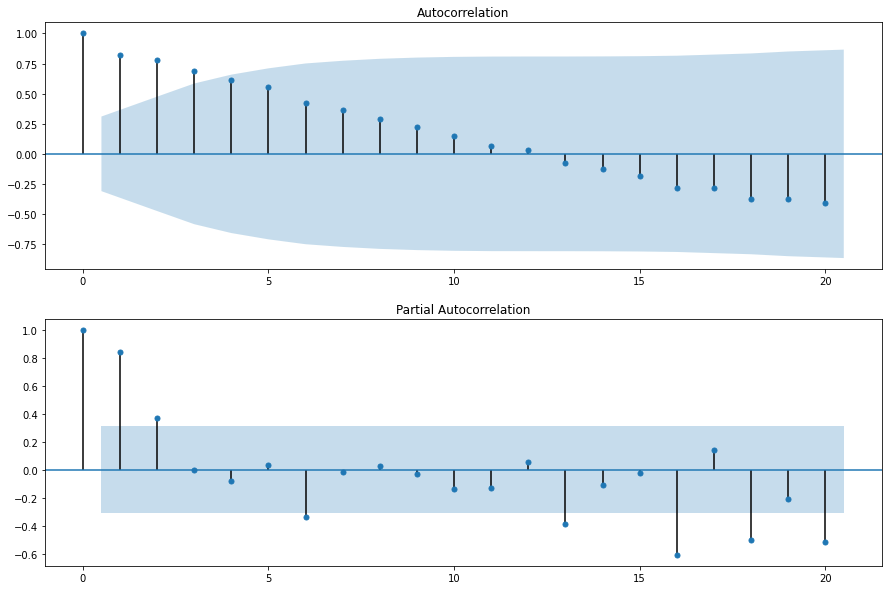

In [26]:
plt.figure(figsize=(15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(dataAR, lags=20, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(dataAR, lags=20, ax=ax)
#plt.tight_layout()
plt.show()

In [27]:
from itertools import product 
# setting initial values and some bounds for them
p = range(0, 5)
d = 1 
q = range(0, 5)

parameters = product(p, q)
parameters_list = list(parameters)
len(parameters_list) 

25

In [28]:
def optimizeARIMA(parameters_list):
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=ARIMA(dataAR, order=(param[0], d, param[1]))
            model_fit = model.fit(disp=False)
            yhat = model_fit.predict(1, len(dataAR)+6, typ='levels')
            dataList = list(dataAR)
            yhatList = list(yhat)
        except:
            continue
        aic = model_fit.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model_fit.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'AIC']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_table

In [29]:
result_table = optimizeARIMA(parameters_list)
result_table.head()

,parameters,AIC
0,"(3, 2)",419.191937
1,"(3, 3)",420.246483
2,"(4, 2)",420.901581
3,"(1, 0)",421.195175
4,"(4, 3)",421.974980


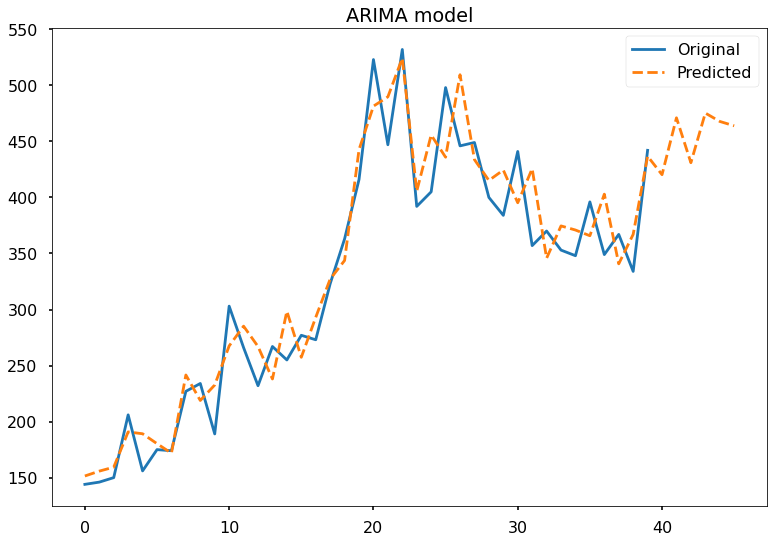

ARIMA AIC: 419.2


In [30]:
p, q = result_table.parameters[0]
model = ARIMA(dataAR, order=(p, 1, q))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(1, len(dataAR)+6, typ='levels')

dataList = list(dataAR)
yhatList = list(yhat)

plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList, label='Original')
plt.plot(yhatList, ls='--', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA model')
plt.show()

aicArima = model_fit.aic
print('ARIMA AIC: %.1f' % aicArima)

# SUMMARY:

**After analyzing the data set, our team learned the following:**

1.   The country suffered the most natural disasters: **China**
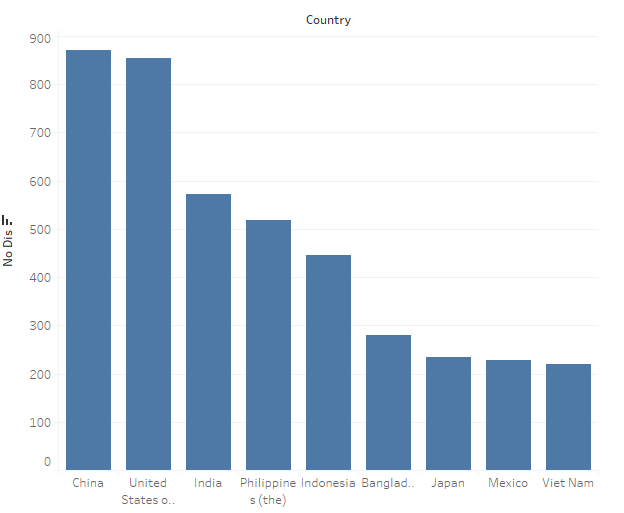
2.   The country is most affected by natural disasters: **China**
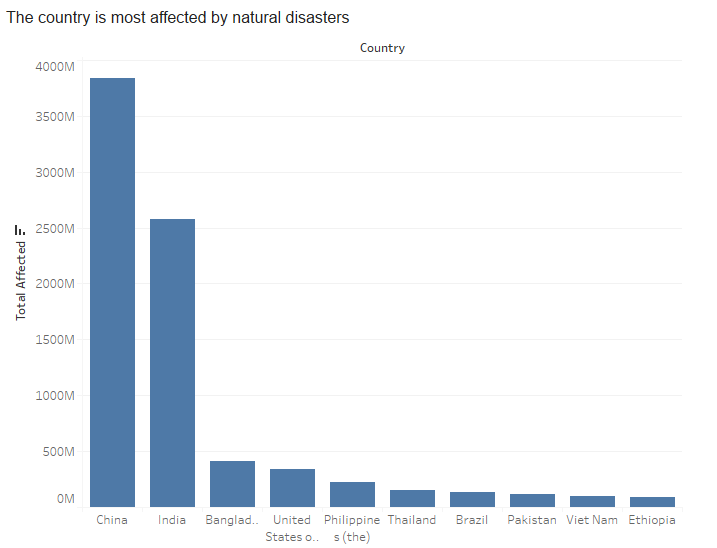
3.   Short-term prediction (6 years)
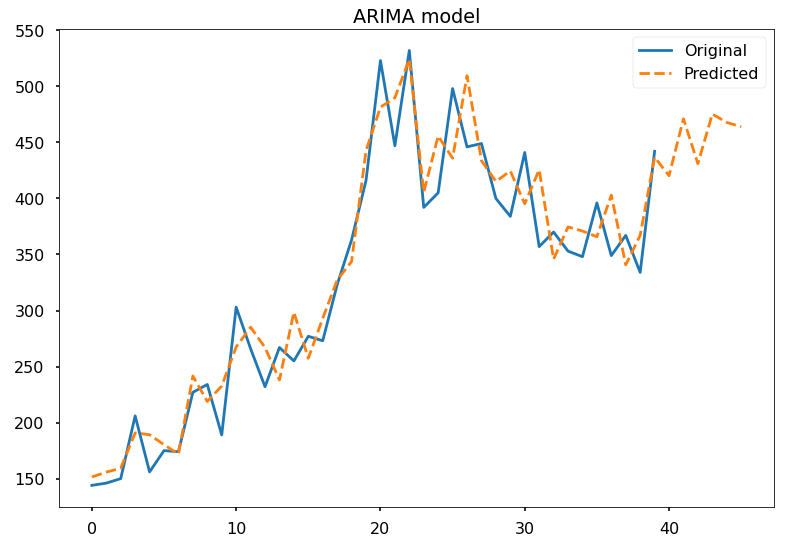

